In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [19]:
# load the data from URL
kiwo_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv'
umsatz_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv'
wetter_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)

# Merge df_umsatz with df_wetter on the 'date' column
df = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')

# Merge the result with df_kiwo on the 'date' column
df = pd.merge(df, df_kiwo, on='Datum', how='left')

print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche
0,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,NaN
1,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,NaN
2,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,NaN
3,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,NaN
4,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,NaN


In [20]:
# Preprocess data
def prepare_data(data):
    # Convert Datum to datetime
    data['Datum'] = pd.to_datetime(data['Datum'])
    
    # Extract additional features from date
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    
    # Create 'temperatur_binned' feature
    def bin_temperature(row):
        month = row['Month']
        temperature = row['Temperatur']
        
        if month in [12, 1, 2]:  # Winter
            if temperature <= 0:
                return 'Very Cold'
            elif temperature <= 5:
                return 'Cold'
            elif temperature <= 10:
                return 'Mild'
            else:
                return 'Warm'
        elif month in [3, 4, 5]:  # Spring
            if temperature <= 10:
                return 'Cool'
            elif temperature <= 15:
                return 'Mild'
            elif temperature <= 25:
                return 'Warm'
            else:
                return 'Hot'
        elif month in [6, 7, 8]:  # Summer
            if temperature <= 15:
                return 'Cool'
            elif temperature <= 20:
                return 'Mild'
            elif temperature <= 30:
                return 'Warm'
            else:
                return 'Hot'
        else:  # Fall
            if temperature <= 10:
                return 'Cool'
            elif temperature <= 15:
                return 'Mild'
            elif temperature <= 25:
                return 'Warm'
            else:
                return 'Hot'

    data['Temperatur_binned'] = data.apply(bin_temperature, axis=1)
    
    # More robust missing value handling
    numeric_columns = ['Bewoelkung', 'Windgeschwindigkeit', 'Wettercode']
    categorical_columns = ['Warengruppe', 'Temperatur_binned']

    # Fill numeric columns with median
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())
    
    # Fill categorical columns with mode
    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    # Handle KielerWoche
    data['KielerWoche'] = data['KielerWoche'].apply(lambda x: 0 if pd.isna(x) else 1)
    
    return data


# Before model training, double-check for NaNs
print("Columns with NaNs:")
print(df.isna().sum())

# Prepare the data
df = prepare_data(df)

df.head()

Columns with NaNs:
Datum                     0
Warengruppe               0
Umsatz                    0
Bewoelkung               70
Temperatur               16
Windgeschwindigkeit      16
Wettercode             2325
KielerWoche            9111
dtype: int64


,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,DayOfWeek,Month,Temperatur_binned
0,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,0,7,Mild
1,2013-07-02,1,159.793757,3.0,17.3125,10.0,28.0,0,1,7,Mild
2,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,2,7,Warm
3,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,3,7,Mild
4,2013-07-05,1,171.280754,5.0,19.9750,12.0,28.0,0,4,7,Mild


Model Performance:
Mean Squared Error: 4973.94
R-squared Score: 0.7162
Model Performance:
Mean Squared Error: 4973.94
R-squared Score: 0.7162
Mean Absolute Percentage Error (MAPE): 33.55%


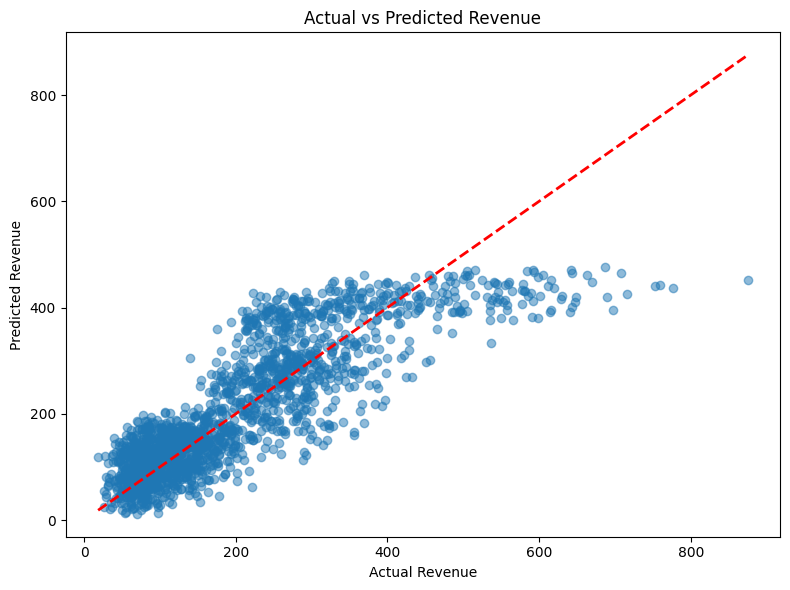


Feature Importance:
                        Feature    Importance
16  Temperatur_binned_Very Cold  1.870503e+14
12       Temperatur_binned_Cold  1.870503e+14
13       Temperatur_binned_Cool  1.870503e+14
14        Temperatur_binned_Hot  1.870503e+14
15       Temperatur_binned_Mild  1.870503e+14
17       Temperatur_binned_Warm  1.870503e+14
7                 Warengruppe_2  7.415975e+12
10                Warengruppe_5  7.415975e+12
8                 Warengruppe_3  7.415975e+12
6                 Warengruppe_1  7.415975e+12
9                 Warengruppe_4  7.415975e+12
11                Warengruppe_6  7.415975e+12
4                     DayOfWeek  1.987486e+01
0                    Bewoelkung  7.042970e+00
3                   KielerWoche  5.470053e+00
5                         Month  3.683537e+00
2                    Wettercode  2.703937e+00
1           Windgeschwindigkeit  1.298385e+00


In [21]:


# Select features and target
features = ['Warengruppe', 'Bewoelkung', 'Temperatur_binned', 'Windgeschwindigkeit', 
            'Wettercode', 'KielerWoche', 'DayOfWeek', 'Month']
X = df[features]
y = df['Umsatz']

# Handle NaNs in the target variable
y = y.fillna(y.median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Bewoelkung', 'Windgeschwindigkeit', 
                                   'Wettercode', 'KielerWoche', 'DayOfWeek', 'Month']),
        ('cat', OneHotEncoder(), ['Warengruppe', 'Temperatur_binned'])
    ],
    remainder='passthrough'
)

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).
    
    Parameters:
    y_true (numpy.ndarray or pandas.Series): The true target values.
    y_pred (numpy.ndarray or pandas.Series): The predicted target values.
    
    Returns:
    float: The Mean Absolute Percentage Error.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")
# Predict and evaluate MEAP
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualize actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.tight_layout()
plt.show()



# Feature importance (for numeric features)
feature_names = (
    list(preprocessor.named_transformers_['num'].get_feature_names_out()) + 
    list(preprocessor.named_transformers_['cat'].get_feature_names_out())
)
coefficients = model.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Function for making predictions
def predict_revenue(input_data):
    return model.predict(input_data)

🚨 **We need to bin temperature and add more variables (e.g. Wochentag, Feiertage, Cruiseships?, Events, Umsatz vom Vortag, etc.)**

To further improve the model's performance, you could consider the following:

- Explore additional features that might be relevant for predicting revenue.
- Try different machine learning algorithms or ensemble methods to see if they can improve the model's predictive power.
- Investigate the distribution of the target variable and consider transformations or normalization techniques to address any skewness or outliers.
- Perform feature selection to identify the most important predictors and potentially remove irrelevant or redundant features.
- Tune the hyperparameters of the model to optimize its performance on the specific dataset.